In [ ]:
!pip install google-cloud-bigquery==1.25.0

In [ ]:
!pip install --upgrade google-cloud-bigquery-storage

In [1]:
from google.cloud import bigquery
client = bigquery.Client()

# Percentage of Purchasers versus Non-Purchasers

In [2]:
sql = """
    WITH 
    unique_visitors AS (
    SELECT COUNT(DISTINCT fullVisitorId) AS all_visitors
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    ),
    purchasers AS (
    SELECT COUNT(DISTINCT fullVisitorId) AS all_purchasers
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE totals.transactions IS NOT NULL
    ),
    non_purchasers AS (
    SELECT COUNT(DISTINCT fullVisitorId) AS all_non_purchasers
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE totals.transactions IS NULL
    )
    SELECT
      all_visitors,
      all_purchasers,
      all_non_purchasers,
      all_purchasers / all_visitors AS purchasers_per,
      all_non_purchasers / all_visitors AS non_purchasers_per
    FROM unique_visitors, purchasers, non_purchasers;
"""
df_purchasers = client.query(sql).to_dataframe()
df_purchasers

,all_visitors,all_purchasers,all_non_purchasers,purchasers_per,non_purchasers_per
0,714167,10022,710928,0.014033,0.995465


# Top 10 Products by Revenue

In [3]:
sql = """
    SELECT P.v2ProductName AS product_name,
      SUM(P.productQuantity) AS qty_sold,
      ROUND(SUM(P.localProductRevenue/1000000), 0) AS product_revenue
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) as H,
    UNNEST (H.product) as P
    GROUP BY product_name
    ORDER BY product_revenue DESC
    LIMIT 10
"""
df_products = client.query(sql).to_dataframe()
df_products

,product_name,qty_sold,product_revenue
0,Google Men's Zip Hoodie,6116,47636.0
1,26 oz Double Wall Insulated Bottle,12963,44454.0
2,Google 22 oz Water Bottle,87090,42995.0
3,Leatherette Journal,22495,38563.0
4,Google Sunglasses,73908,35490.0
5,Google Metallic Notebook Set,33307,28847.0
6,Google Men's 100% Cotton Short Sleeve Hero Tee...,11257,28048.0
7,Recycled Paper Journal Set,40565,27918.0
8,Google Men's 100% Cotton Short Sleeve Hero Tee...,14292,27856.0
9,Google Hard Cover Journal,13267,25433.0


<AxesSubplot:xlabel='product_name'>

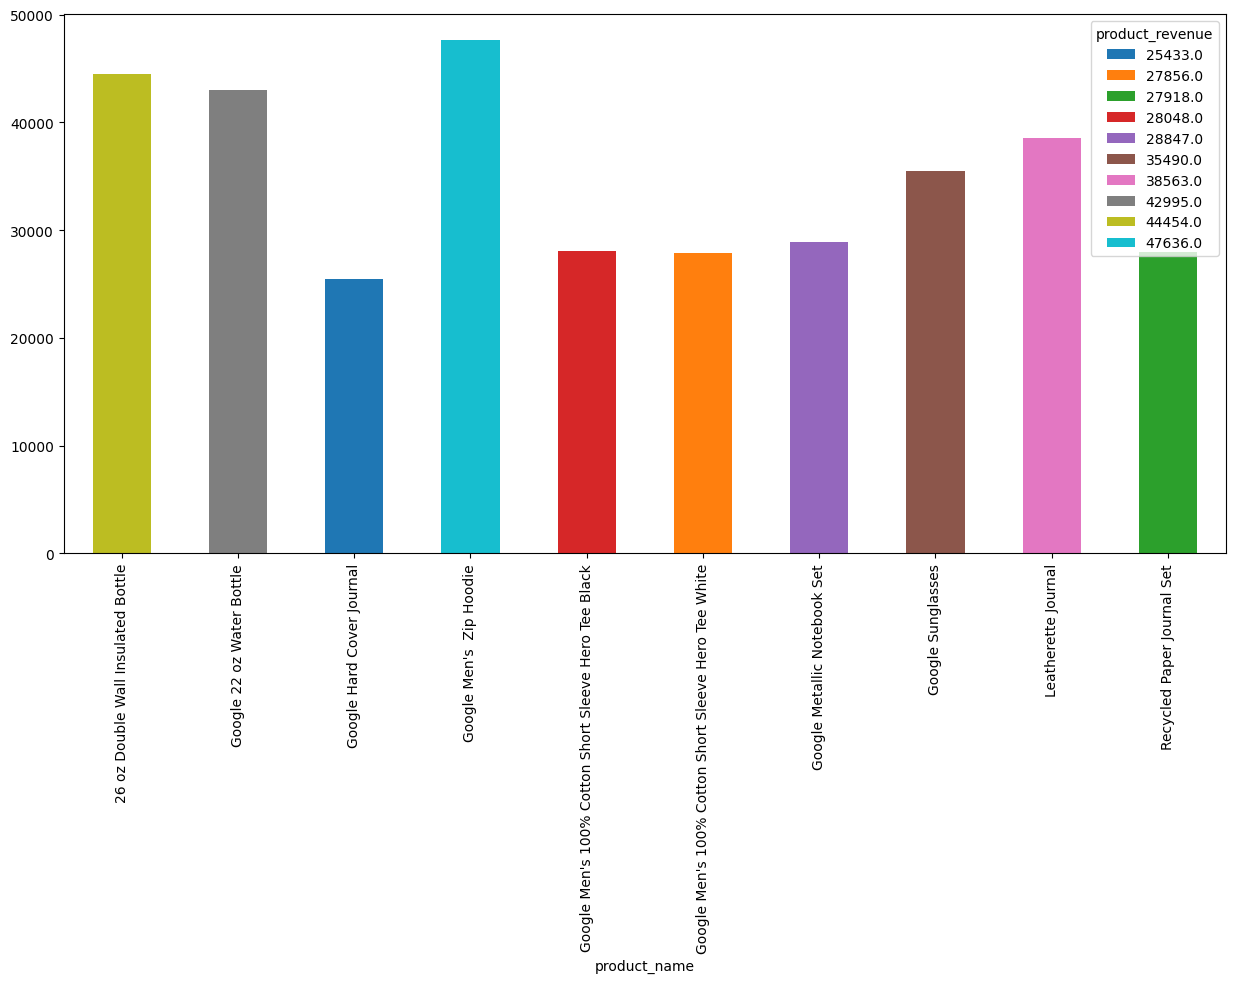

In [4]:
p_products = df_products.pivot(index='product_name', columns='product_revenue', values='product_revenue')
p_products.plot(kind='bar', stacked=True, figsize=(15, 7))

# Top 10 Countries by Visitors

In [5]:
sql = """
    SELECT
        COUNT(DISTINCT fullVisitorId) AS unique_visitors,
        IFNULL(geoNetwork.country, "") AS country
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    GROUP BY country
    ORDER BY unique_visitors DESC
    Limit 10
"""
df_countries = client.query(sql).to_dataframe()
df_countries

,unique_visitors,country
0,251830,United States
1,45289,India
2,31653,United Kingdom
3,23332,Vietnam
4,19356,Canada
5,19153,Turkey
6,18792,Thailand
7,17963,Brazil
8,17069,Germany
9,16041,Japan


<AxesSubplot:xlabel='country'>

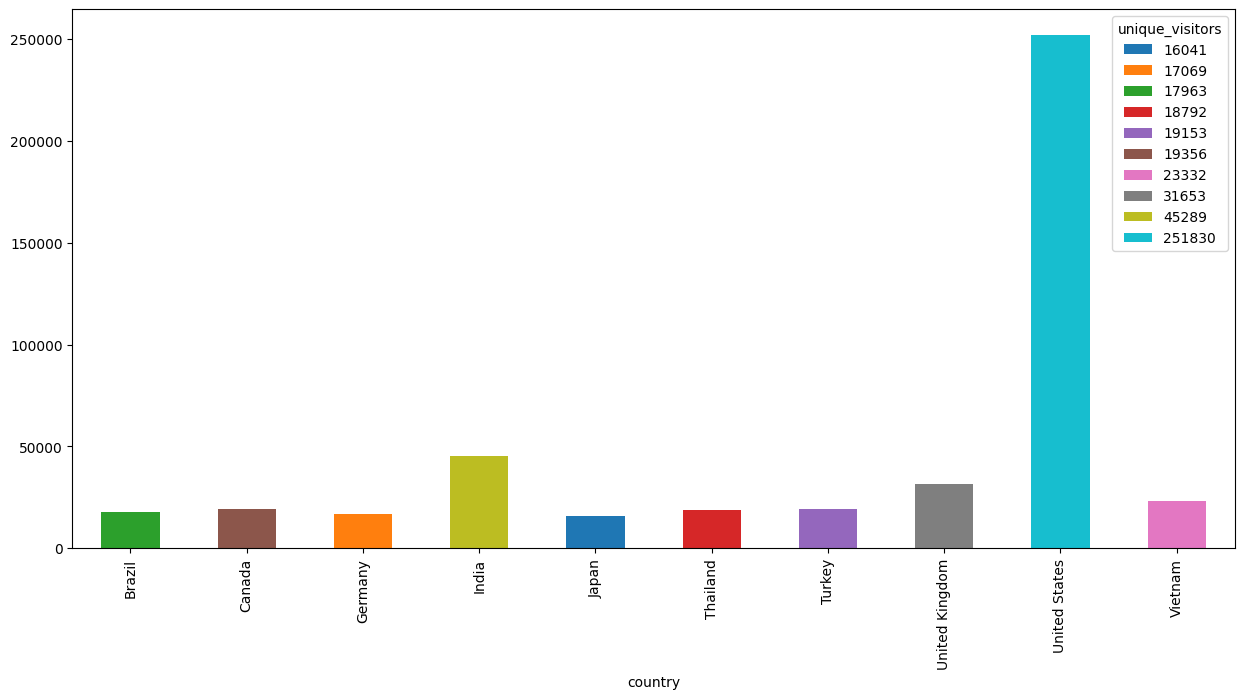

In [6]:
p_countries = df_countries.pivot(index='country', columns='unique_visitors', values='unique_visitors')
p_countries.plot(kind='bar', stacked=True, figsize=(15, 7))

# Visitors by Channel Grouping

In [7]:
sql = """
    SELECT
      COUNT(DISTINCT fullVisitorId) AS unique_visitors,
      channelGrouping AS channel
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    GROUP BY channel
    ORDER BY channel DESC
"""
df_channel = client.query(sql).to_dataframe()
df_channel

,unique_visitors,channel
0,212374,Social
1,65661,Referral
2,18702,Paid Search
3,311607,Organic Search
4,4103,Display
5,109830,Direct
6,13400,Affiliates
7,90,(Other)


<AxesSubplot:xlabel='channel'>

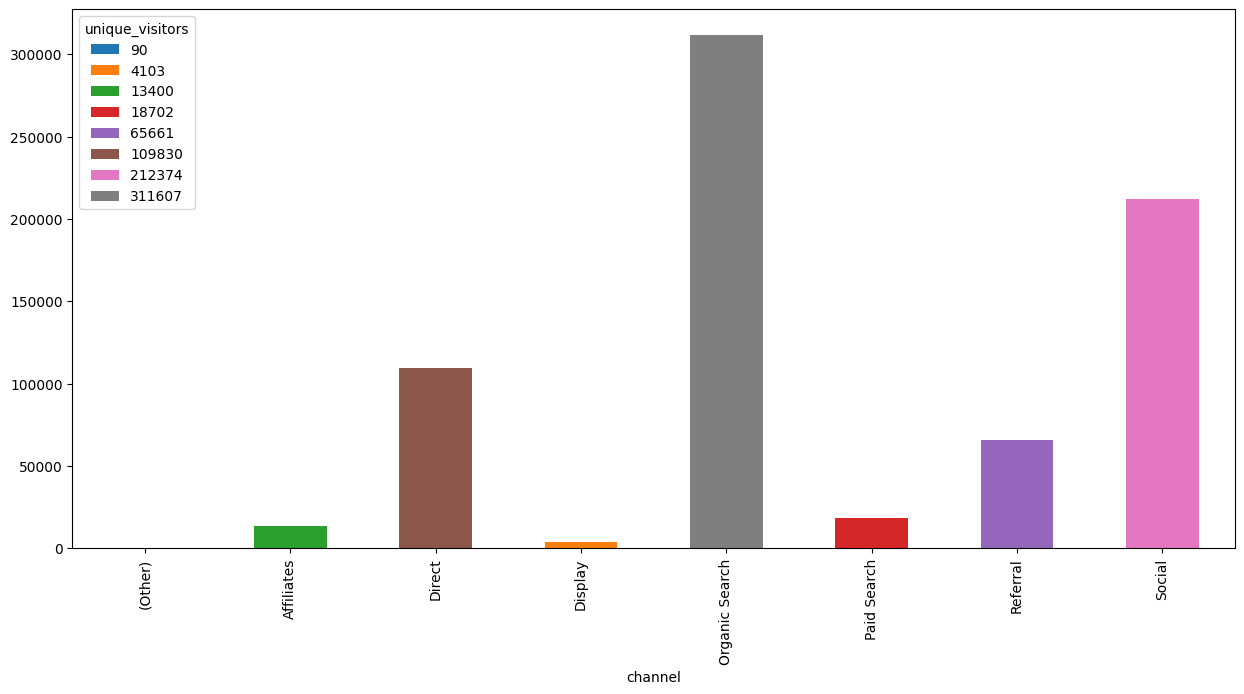

In [8]:
p_channel = df_channel.pivot(index='channel', columns='unique_visitors', values='unique_visitors')
p_channel.plot(kind='bar', stacked=True, figsize=(15, 7))